In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import timeit
import time
import warnings
warnings.filterwarnings('ignore')
from math import exp
plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline

In [2]:
data = pd.read_csv('cleaned_data_final.csv')
data

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,2.178008,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,1.044105,1.000000
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,2.178008,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,1.002393,1.001244
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,1.137948,1.288057
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,1.201338,1.106055
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,1.499767,1.029441


In [64]:
start_date = data['Date'].min()
end_date = start_date + pd.Timedelta(weeks = 2)
filtered_df = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
num_rows = filtered_df.shape[0]

In [65]:
num_rows 

3477

In [60]:
two_months_ago = dt.datetime.today() - pd.DateOffset(months=2)
last_two_months = data['Date'] >= two_months_ago

In [61]:
df_last_two_months = data[last_two_months]


In [62]:
count_last_two_months = len(df_last_two_months)
count_last_two_months

0

In [3]:
data.describe()

,Recnum,Cardnum,Amount,Fraud,U*_cardnum,U*_merchnum
count,96397.000000,9.639700e+04,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,5.142202e+09,395.858494,0.010986,1.342859,1.825960
std,27945.003883,5.565825e+04,832.330197,0.104236,0.671819,7.590069
min,1.000000,5.142110e+09,0.010000,0.000000,1.000000,1.000000
25%,24154.000000,5.142152e+09,33.460000,0.000000,1.083485,1.005353
50%,48365.000000,5.142196e+09,137.980000,0.000000,1.191301,1.073167
75%,72578.000000,5.142245e+09,428.250000,0.000000,1.369983,1.270492
max,96753.000000,5.142847e+09,47900.000000,1.000000,13.371199,165.145985


# Data Preparation

In [4]:
##convert date to datetime 
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
data.dropna(how='all', axis=1,inplace=True)

In [6]:
data['Fraud']=data['Fraud'].astype(int)
data['Recnum']=data['Recnum'].astype(int)
data['Date'] = pd.to_datetime(data['Date'],format='%m/%d/%y')

In [7]:
##find the day of the week
data['Dow'] = data.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [8]:
##convert cardnumber to from integer to string
data['Cardnum']=data['Cardnum'].astype(str)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96397 entries, 0 to 96396
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int32         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int32         
 10  U*_cardnum         96397 non-null  float64       
 11  U*_merchnum        96397 non-null  float64       
 12  Dow                96397 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(2), object(7)
memory 

In [10]:
## we want not to use oot for target encoding variables
train_test = data[data.Date < '2010-11-01']  ##training data includes 11 months and the test data is the last month.
c = 4; nmid =20; y_avg=train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1+np.exp(-(num-nmid)/c))
data['Dow_Risk'] = data.Dow.map(y_dow_smooth)

In [11]:
y_dow = y_dow.reset_index()
cats=['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
y_dow['Dow'] = pd.Categorical(y_dow['Dow'], categories = cats, ordered=True)
y_dow = y_dow.sort_values('Dow')
y_dow = y_dow.set_index('Dow')

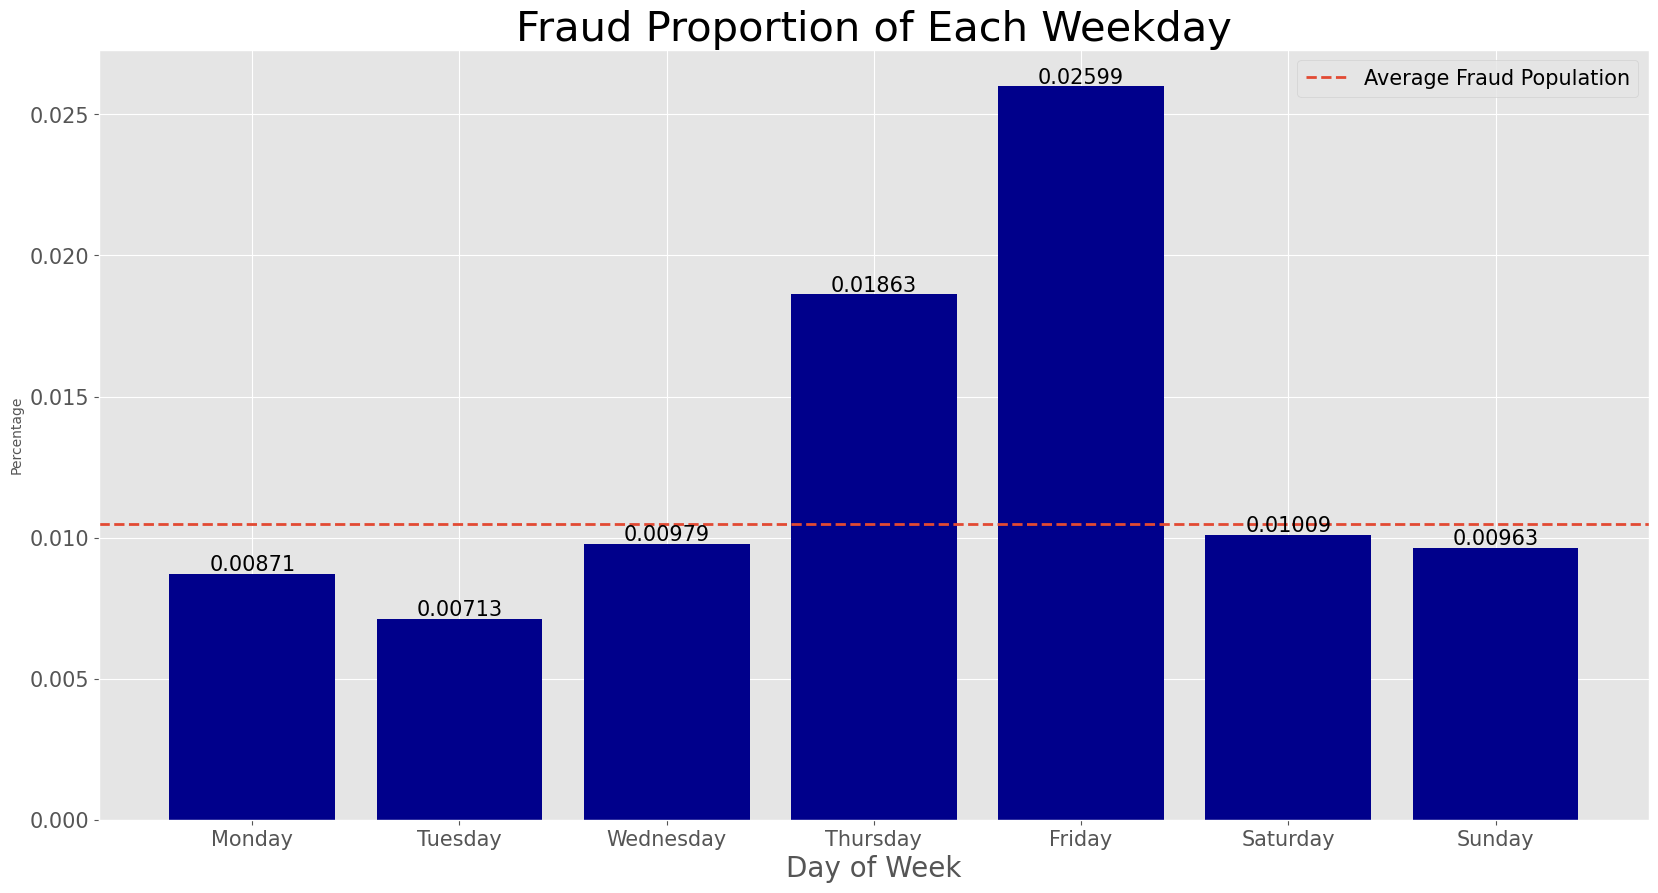

In [12]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow,
       x=y_dow.index,
       height ='Fraud',
       color = 'darkblue')
ax.axhline(y=y_avg, ls ='--', lw=2, label='Average Fraud Population')

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v, 'Fraud']+0.0001, round(y_dow.loc[v,'Fraud'], 5), horizontalalignment ='center', fontsize =15)
    
plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel('Day of Week', fontsize =20)
plt.ylabel('Percentage', fontsize =10)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title('Fraud Proportion of Each Weekday', fontsize =30)

plt.show()

##Thursday and Friday have the highest fraud proportion

In [13]:
data

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,U*_cardnum,U*_merchnum,Dow,Dow_Risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,2.178008,1.000000,Friday,0.025994
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,1.604857,1.001244,Friday,0.025994
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,2.368143,1.025818,Friday,0.025994
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,1.044105,1.000000,Friday,0.025994
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,2.178008,1.000000,Friday,0.025994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,1.002393,1.001244,Friday,0.025994
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,1.137948,1.288057,Friday,0.025994
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,1.201338,1.106055,Friday,0.025994
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,1.499767,1.029441,Friday,0.025994


# Making Entities

In [14]:
data.columns = ['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch_description',
       'Merch_state', 'Merch_zip', 'Transtype', 'Amount', 'Fraud',
       'U*_cardnum', 'U*_merchnum', 'Dow', 'Dow_risk']

In [15]:
data['cardnum_merchnum'] = data['Cardnum'] + data['Merchnum']
data['cardnum_merchzip'] = data['Cardnum'] + data['Merch_zip'].apply(lambda x: str(int(float(x))) if x != 'unknown' else str(x))
data['cardnum_merchstate'] = data['Cardnum'] + data['Merch_state']
data['cardnum_merchdes'] = data['Cardnum'] + data['Merch_description']
data['merchnum_merchzip'] = data['Merchnum'] + data['Merch_zip'].apply(lambda x: str(int(float(x))) if x != 'unknown' else str(x))
data['merchnum_merchstate'] = data['Merchnum'] + data['Merch_state']
data['merchnum_merchdes'] = data['Merchnum'] + data['Merch_description']

In [16]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch_description',
       'Merch_state', 'Merch_zip', 'Transtype', 'Amount', 'Fraud',
       'U*_cardnum', 'U*_merchnum', 'Dow', 'Dow_risk', 'cardnum_merchnum',
       'cardnum_merchzip', 'cardnum_merchstate', 'cardnum_merchdes',
       'merchnum_merchzip', 'merchnum_merchstate', 'merchnum_merchdes'],
      dtype='object')

In [17]:
data

,Recnum,Cardnum,Date,Merchnum,Merch_description,Merch_state,Merch_zip,Transtype,Amount,Fraud,...,U*_merchnum,Dow,Dow_risk,cardnum_merchnum,cardnum_merchzip,cardnum_merchstate,cardnum_merchdes,merchnum_merchzip,merchnum_merchstate,merchnum_merchdes
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,1.000000,Friday,0.025994,51421904395509006296254,514219043938118,5142190439TN,5142190439FEDEX SHP 12/23/09 AB#,550900629625438118,5509006296254TN,5509006296254FEDEX SHP 12/23/09 AB#
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,1.001244,Friday,0.025994,514218397361003026333,51421839731803,5142183973MA,5142183973SERVICE MERCHANDISE #81,610030263331803,61003026333MA,61003026333SERVICE MERCHANDISE #81
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,1.025818,Friday,0.025994,51421317214503082993600,514213172120706,5142131721MD,5142131721OFFICE DEPOT #191,450308299360020706,4503082993600MD,4503082993600OFFICE DEPOT #191
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,1.000000,Friday,0.025994,51421484525509006296254,514214845238118,5142148452TN,5142148452FEDEX SHP 12/28/09 AB#,550900629625438118,5509006296254TN,5509006296254FEDEX SHP 12/28/09 AB#
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,1.000000,Friday,0.025994,51421904395509006296254,514219043938118,5142190439TN,5142190439FEDEX SHP 12/23/09 AB#,550900629625438118,5509006296254TN,5509006296254FEDEX SHP 12/23/09 AB#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,...,1.001244,Friday,0.025994,51422760533500000006160,514227605341042,5142276053KY,5142276053BEST BUY 00001610,350000000616041042,3500000006160KY,3500000006160BEST BUY 00001610
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,...,1.288057,Friday,0.025994,51422257018090710030950,514222570145248,5142225701OH,5142225701MARKUS OFFICE SUPPLIES,809071003095045248,8090710030950OH,8090710030950MARKUS OFFICE SUPPLIES
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,...,1.106055,Friday,0.025994,51422264864503057341100,514222648645150,5142226486OH,"5142226486TECH PAC, INC",450305734110045150,4503057341100OH,"4503057341100TECH PAC, INC"
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,...,1.029441,Friday,0.025994,51422446198834000695412,514224461992656,5142244619CA,5142244619BUY.COM,883400069541292656,8834000695412CA,8834000695412BUY.COM


In [18]:
for i in list(data.iloc[:,np.r_[:,18:21]]):
    data['cardnum_'+i]=data.Cardnum+data[i]

In [19]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch_description',
       'Merch_state', 'Merch_zip', 'Transtype', 'Amount', 'Fraud',
       'U*_cardnum', 'U*_merchnum', 'Dow', 'Dow_risk', 'cardnum_merchnum',
       'cardnum_merchzip', 'cardnum_merchstate', 'cardnum_merchdes',
       'merchnum_merchzip', 'merchnum_merchstate', 'merchnum_merchdes',
       'cardnum_merchnum_merchzip', 'cardnum_merchnum_merchstate',
       'cardnum_merchnum_merchdes'],
      dtype='object')

In [20]:
data.info

<bound method DataFrame.info of        Recnum     Cardnum       Date       Merchnum        Merch_description  \
0           1  5142190439 2010-01-01  5509006296254   FEDEX SHP 12/23/09 AB#   
1           2  5142183973 2010-01-01    61003026333  SERVICE MERCHANDISE #81   
2           3  5142131721 2010-01-01  4503082993600        OFFICE DEPOT #191   
3           4  5142148452 2010-01-01  5509006296254   FEDEX SHP 12/28/09 AB#   
4           5  5142190439 2010-01-01  5509006296254   FEDEX SHP 12/23/09 AB#   
...       ...         ...        ...            ...                      ...   
96392   96749  5142276053 2010-12-31  3500000006160   BEST BUY      00001610   
96393   96750  5142225701 2010-12-31  8090710030950   MARKUS OFFICE SUPPLIES   
96394   96751  5142226486 2010-12-31  4503057341100            TECH PAC, INC   
96395   96752  5142244619 2010-12-31  8834000695412                  BUY.COM   
96396   96753  5142243247 2010-12-31  9108347680006    STAPLES NATIONAL #471   

      M

In [21]:
entities=list(data.iloc[:,np.r_[1, 3:6, 14:24]].columns)
entities

['Cardnum',
 'Merchnum',
 'Merch_description',
 'Merch_state',
 'cardnum_merchnum',
 'cardnum_merchzip',
 'cardnum_merchstate',
 'cardnum_merchdes',
 'merchnum_merchzip',
 'merchnum_merchstate',
 'merchnum_merchdes',
 'cardnum_merchnum_merchzip',
 'cardnum_merchnum_merchstate',
 'cardnum_merchnum_merchdes']

In [22]:
len(entities)

14

# Creating variables

In [23]:
df1=data.copy()
final=data.copy()
df1['check_date']=df1.Date
df1['check_record']=df1.Recnum
numvars = 1
final.shape

(96397, 24)

# Amount Variables

In [24]:
start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')




Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Run time for the last entity ----------------- 21.515408s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 1

cardnum_merchnum_merchzip_count_3 ---> Done
cardnum_merchnum_merchzip amount variables over past 3 ---> Done
cardnum_merchnum_merchzip_count_7 ---> Done
cardnum_merchnum_merchzip amount variables over past 7 ---> Done
cardnum_merchnum_merchzip_count_14 ---> Done
cardnum_merchnum_merchzip amount variables over past 14 ---> Done
cardnum_merchnum_merchzip_count_30 ---> Done
cardnum_merchnum_merchzip amount variables over past 30 ---> Done
cardnum_merchnum_merchzip_count_60 ---> Done
cardnum_merchnum_merchzip amount variables over past 60 ---> Done
Run time for the last entity ----------------- 2.077749199999971s

cardnum_merchnum_merchstate_day_since ---> Done
cardnum_merchnum_merchstate_count_0 ---> Done
cardnum_merchnum_merchstate amount variables over past 0 ---> Done
cardnum_merchnum_merchstate_count_1 ---> Done
cardnum_merchnum_merchstate amount variables over past 1 ---> Done
cardnum_merchnum_merchstate_count_3 ---> Done
cardnum_merchnum_merchstate amount variables over past 3 ---> 

In [25]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 896   total variables: 897


# Frequency Variables

In [26]:
# frequencies
df2 = data.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')


In [27]:
#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30,60]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)


In [28]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 10 total variables: 907


# Velocity Change Variables

In [29]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30','60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            

In [30]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 112 total variables: 1019


# Cross entity uniqueness variables

In [31]:
# Cross entity uniqueness variables
for entity in entities: 
    for field in entities:
        st = timeit.default_timer()
        if entity != field:
            new_attributes = f'{entity}_{field}_nunique'
            if new_attributes not in list(final.columns):
                mapper3 = final.groupby(entity)[field].nunique()
                final[new_attributes] = final[entity].map(mapper3)
        print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')
            


Run time for entity Cardnum in field Cardnum ---> Done
Run time for entity Cardnum in field Merchnum ---> Done
Run time for entity Cardnum in field Merch_description ---> Done
Run time for entity Cardnum in field Merch_state ---> Done
Run time for entity Cardnum in field cardnum_merchnum ---> Done
Run time for entity Cardnum in field cardnum_merchzip ---> Done
Run time for entity Cardnum in field cardnum_merchstate ---> Done
Run time for entity Cardnum in field cardnum_merchdes ---> Done
Run time for entity Cardnum in field merchnum_merchzip ---> Done
Run time for entity Cardnum in field merchnum_merchstate ---> Done
Run time for entity Cardnum in field merchnum_merchdes ---> Done
Run time for entity Cardnum in field cardnum_merchnum_merchzip ---> Done
Run time for entity Cardnum in field cardnum_merchnum_merchstate ---> Done
Run time for entity Cardnum in field cardnum_merchnum_merchdes ---> Done
Run time for entity Merchnum in field Cardnum ---> Done
Run time for entity Merchnum in f

Run time for entity merchnum_merchzip in field cardnum_merchzip ---> Done
Run time for entity merchnum_merchzip in field cardnum_merchstate ---> Done
Run time for entity merchnum_merchzip in field cardnum_merchdes ---> Done
Run time for entity merchnum_merchzip in field merchnum_merchzip ---> Done
Run time for entity merchnum_merchzip in field merchnum_merchstate ---> Done
Run time for entity merchnum_merchzip in field merchnum_merchdes ---> Done
Run time for entity merchnum_merchzip in field cardnum_merchnum_merchzip ---> Done
Run time for entity merchnum_merchzip in field cardnum_merchnum_merchstate ---> Done
Run time for entity merchnum_merchzip in field cardnum_merchnum_merchdes ---> Done
Run time for entity merchnum_merchstate in field Cardnum ---> Done
Run time for entity merchnum_merchstate in field Merchnum ---> Done
Run time for entity merchnum_merchstate in field Merch_description ---> Done
Run time for entity merchnum_merchstate in field Merch_state ---> Done
Run time for en

In [32]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 182 total variables: 1201


# Accelation

In [33]:
import time
begin=time.time()
######################## acceleration
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30','60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

Cardnum
Merchnum
Merch_description
Merch_state
cardnum_merchnum
cardnum_merchzip
cardnum_merchstate
cardnum_merchdes
merchnum_merchzip
merchnum_merchstate
merchnum_merchdes
cardnum_merchnum_merchzip
cardnum_merchnum_merchstate
cardnum_merchnum_merchdes
Total run time:0.00min


In [34]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 112 total variables: 1313


# Variability

In [35]:
# variability
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30,60]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')


Run time for the last entity ----------------- 0.15082170000005135s
Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 --->

cardnum_merchstate_variability_max_1 ---> Done
cardnum_merchstate_variability_med_1 ---> Done
cardnum_merchstate amount variables over past 1 ---> Done
cardnum_merchstate_variability_avg_3 ---> Done
cardnum_merchstate_variability_max_3 ---> Done
cardnum_merchstate_variability_med_3 ---> Done
cardnum_merchstate amount variables over past 3 ---> Done
cardnum_merchstate_variability_avg_7 ---> Done
cardnum_merchstate_variability_max_7 ---> Done
cardnum_merchstate_variability_med_7 ---> Done
cardnum_merchstate amount variables over past 7 ---> Done
cardnum_merchstate_variability_avg_14 ---> Done
cardnum_merchstate_variability_max_14 ---> Done
cardnum_merchstate_variability_med_14 ---> Done
cardnum_merchstate amount variables over past 14 ---> Done
cardnum_merchstate_variability_avg_30 ---> Done
cardnum_merchstate_variability_max_30 ---> Done
cardnum_merchstate_variability_med_30 ---> Done
cardnum_merchstate amount variables over past 30 ---> Done
cardnum_merchstate_variability_avg_60 ---> D

cardnum_merchnum_merchzip_variability_avg_60 ---> Done
cardnum_merchnum_merchzip_variability_max_60 ---> Done
cardnum_merchnum_merchzip_variability_med_60 ---> Done
cardnum_merchnum_merchzip amount variables over past 60 ---> Done
Run time for the last entity ----------------- 1.8006485000000794s
cardnum_merchnum_merchstate_variability_avg_0 ---> Done
cardnum_merchnum_merchstate_variability_max_0 ---> Done
cardnum_merchnum_merchstate_variability_med_0 ---> Done
cardnum_merchnum_merchstate amount variables over past 0 ---> Done
cardnum_merchnum_merchstate_variability_avg_1 ---> Done
cardnum_merchnum_merchstate_variability_max_1 ---> Done
cardnum_merchnum_merchstate_variability_med_1 ---> Done
cardnum_merchnum_merchstate amount variables over past 1 ---> Done
cardnum_merchnum_merchstate_variability_avg_3 ---> Done
cardnum_merchnum_merchstate_variability_max_3 ---> Done
cardnum_merchnum_merchstate_variability_med_3 ---> Done
cardnum_merchnum_merchstate amount variables over past 3 ---> Do

In [36]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 294 total variables: 1607


# Making New Variables

In [37]:
df1=final.copy()

In [38]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch_description',
       'Merch_state', 'Merch_zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'cardnum_merchnum_merchdes_variability_med_7',
       'cardnum_merchnum_merchdes_variability_avg_14',
       'cardnum_merchnum_merchdes_variability_max_14',
       'cardnum_merchnum_merchdes_variability_med_14',
       'cardnum_merchnum_merchdes_variability_avg_30',
       'cardnum_merchnum_merchdes_variability_max_30',
       'cardnum_merchnum_merchdes_variability_med_30',
       'cardnum_merchnum_merchdes_variability_avg_60',
       'cardnum_merchnum_merchdes_variability_max_60',
       'cardnum_merchnum_merchdes_variability_med_60'],
      dtype='object', length=1630)

In [39]:
df1['Merch_description'].str.contains("GASES",case=False)

0        False
1        False
2        False
3        False
4        False
         ...  
96392    False
96393    False
96394    False
96395    False
96396    False
Name: Merch_description, Length: 96397, dtype: bool

In [40]:
df1['gas']=0
df1['online']=0
df1['gas']=df1['Merch_description'].str.contains("GASES",case=False)
df1['online']=df1['Merch_description'].str.contains(".COM",case=False)

In [41]:
df1['online'].sum()

6446

In [42]:
df1['gas'].sum()

92

In [43]:
df2 = df1.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum','gas','online']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
# temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
#groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    temp2 = pd.merge(df_2, df_s, left_on = grouper, right_on = grouper)
    for d in [0,1,3,7]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            #print('-------------------')
            #print('d: ', d)
            #print('dd: ', dd)
            numerator = numerator_df.groupby(grouper)['gas'].sum()
            colname = 'gas_count_' + grouper + '_' + '_over_'+str(d) 
            final[colname] = final[grouper].map(numerator)
#print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

In [44]:
df2 = df1.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum','gas','online']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
# temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
#groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    temp2 = pd.merge(df_2, df_s, left_on = grouper, right_on = grouper)
    for d in [0,1,3,7]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            #print('-------------------')
            #print('d: ', d)
            #print('dd: ', dd)
            numerator = numerator_df.groupby(grouper)['online'].sum()
            colname = 'online_count_' + grouper + '_' + '_over_'+str(d) 
            final[colname] = final[grouper].map(numerator)
#print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

In [45]:
numvars_new = len(final.columns)- 23 - numvars
numvars = len(final.columns) - 23
print("new variables:",numvars_new, "total variables:",numvars)

new variables: 8 total variables: 1615


In [46]:
final.shape

(96397, 1638)

In [47]:
import time
final.columns.to_list()
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

Total run time:10.64min


In [48]:
print('duration:',dt.datetime.now() - start_time)

duration: 0:22:17.553643


In [49]:
# %%time
# final.drop(columns=entities,inplace=True)
# final.head()

In [52]:
%%time
final.to_csv('final_variable_before_drop_date.csv',index=False)

Wall time: 1min 55s


In [50]:
%%time
final.drop(columns=['Date','Transtype','Dow'],inplace=True)
final.head()

Wall time: 672 ms


,Recnum,Cardnum,Merchnum,Merch_description,Merch_state,Merch_zip,Amount,Fraud,U*_cardnum,U*_merchnum,...,cardnum_merchnum_merchdes_variability_max_60,cardnum_merchnum_merchdes_variability_med_60,gas_count_Cardnum__over_0,gas_count_Cardnum__over_1,gas_count_Cardnum__over_3,gas_count_Cardnum__over_7,online_count_Cardnum__over_0,online_count_Cardnum__over_1,online_count_Cardnum__over_3,online_count_Cardnum__over_7
0,1,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,3.62,0,2.178008,1.000000,...,0.0,0.0,0,0,0,0,4,4,8,14
1,2,5142183973,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,31.42,0,1.604857,1.001244,...,0.0,0.0,1,1,1,5,19,27,37,60
2,3,5142131721,4503082993600,OFFICE DEPOT #191,MD,20706.0,178.49,0,2.368143,1.025818,...,0.0,0.0,0,0,0,0,67,99,161,271
3,4,5142148452,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,3.62,0,1.044105,1.000000,...,0.0,0.0,0,0,0,0,1,26,31,73
4,5,5142190439,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,3.62,0,2.178008,1.000000,...,0.0,0.0,0,0,0,0,4,4,8,14


In [51]:
%%time
final.to_csv('final_variable.csv',index=False)

Wall time: 1min 49s
